# EAS Testing - PCMark benchmark on Android

The goal of this experiment is to run benchmarks on a Nexus N5X running Android with an EAS kernel and collect results. The analysis phase will consist in comparing EAS with other schedulers, that is comparing *sched* governor with:

    - interactive
    - performance
    - powersave
    - ondemand
    
The benchmark we will be using is ***PCMark*** (https://www.futuremark.com/benchmarks/pcmark-android). You will need to **manually install** the app on the Android device in order to run this Notebook.

When opinening PCMark for the first time you will need to Install the work benchmark from inside the app.

In [27]:
import logging
reload(logging)
log_fmt = '%(asctime)-9s %(levelname)-8s: %(message)s'
logging.basicConfig(format=log_fmt)

# Change to info once the notebook runs ok
logging.getLogger().setLevel(logging.INFO)

In [28]:
%pylab inline

import copy
import os
from time import sleep
from subprocess import Popen

# Support to access the remote target
import devlib
from env import TestEnv

# Support for trace events analysis
from trace import Trace
from trace_analysis import TraceAnalysis

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Test Environment set up

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in `my_target_conf`. Run `adb devices` on your host to get the ID.

In [29]:
# Setup a target configuration
my_target_conf = {
    
    # Target platform and board
    "platform"    : 'android',
    
    # Device ID
    # "device" : "00b1346f0878ccb1",
    
    # Define devlib modules to load
    "modules"     : [
        'cpufreq'       # enable CPUFreq support
    ],
}

In [30]:
my_tests_conf = {

    # Folder where all the results will be collected
    "results_dir" : "AndroidN5X_PCMark",

    # Platform configurations to test
    "confs" : [
        {
            "tag"            : "pcmark",
            "flags"          : "ftrace",           # Enable FTrace events
            "sched_features" : "ENERGY_AWARE",     # enable EAS
        },
    ],
}

In [31]:
# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

# Support Functions

This set of support functions will help us running the benchmark using different CPUFreq governors.

In [32]:
def set_performance():
    target.cpufreq.set_all_governors('performance')

def set_powersave():
    target.cpufreq.set_all_governors('powersave')

def set_interactive():
    target.cpufreq.set_all_governors('interactive')

def set_sched():
    target.cpufreq.set_all_governors('sched')

def set_ondemand():
    target.cpufreq.set_all_governors('ondemand')
    
    for cpu in target.list_online_cpus():
        tunables = target.cpufreq.get_governor_tunables(cpu)
        target.cpufreq.set_governor_tunables(
            cpu,
            'ondemand',
            **{'sampling_rate' : tunables['sampling_rate_min']}
        )

In [33]:
# CPUFreq configurations to test
confs = {
#    'performance' : {
 #       'label' : 'prf',
  #      'set' :  set_performance,
   # },
#    'powersave' : {
 #       'label' : 'pws',
  #      'set' :  set_powersave,
   # },
     'interactive' : {
         'label' : 'int',
         'set' :  set_interactive,
     },
    'sched' : {
        'label' : 'sch',
        'set' :  set_sched,
    },
#    'ondemand' : {
 #       'label' : 'odm',
  #      'set' :  set_ondemand,
   # }
}

# The set of results for each comparison test
results = {}

In [34]:
def check_packages(pkgname):
    try:
        output = target.execute('pm list packages -f | grep -i {}'.format(pkgname))
    except Exception:
        raise RuntimeError('Package: [{}] not availabe on target'.format(pkgname))

# Check for specified PKG name being available on target
check_packages('com.futuremark.pcmark.android.benchmark')

In [35]:
def pcmark_run(exp_dir):
    # Unlock device screen (assume no password required)
    target.execute('input keyevent 82')
    # Start PCMark on the target device
    target.execute('am start -n com.futuremark.pcmark.android.benchmark/com.futuremark.gypsum.activity.WebViewMainActivity')
    # Wait few seconds to make sure the app is loaded
    sleep(5)
    
    # Flush entire log
    target.clear_logcat()
    
    # Run performance workload (assume screen is vertical)
    target.execute('input tap 750 1450')
    # Wait for completion (7 minutes in total) and collect log
    log_file = os.path.join(exp_dir, 'log.txt')
    # Wait 5 minutes
    sleep(300)
    # Start collecting the log
    with open(log_file, 'w') as log:
        logcat = Popen(['adb logcat', 'com.futuremark.pcmandroid.VirtualMachineState:*', '*:S'],
                       stdout=log,
                       shell=True)
        # Wait additional two minutes for benchmark to complete
        sleep(120)

        # Terminate logcat
        logcat.kill()

    # Get scores from logcat
    score_file = os.path.join(exp_dir, 'score.txt')
    os.popen('grep -o "PCMA_.*_SCORE .*" {} | sed "s/ = / /g" | sort -u > {}'.format(log_file, score_file))
    
    # Close application
    target.execute('am force-stop com.futuremark.pcmark.android.benchmark')
    
    return score_file

In [36]:
def experiment(governor, exp_dir):
    os.system('mkdir -p {}'.format(exp_dir));

    logging.info('------------------------')
    logging.info('Run workload using %s governor', governor)
    confs[governor]['set']()

    ### Run the benchmark ###
    score_file = pcmark_run(exp_dir)
    
    # Save the score as a dictionary
    scores = dict()
    with open(score_file, 'r') as f:
        lines = f.readlines()
        for l in lines:
            info = l.split()
            scores.update({info[0] : float(info[1])})
    
    # return all the experiment data
    return {
        'dir'        : exp_dir,
        'scores'     : scores,
    }

# Run PCMark and collect scores

In [37]:
# Run the benchmark in all the configured governors
for governor in confs:
    test_dir = os.path.join(te.res_dir, governor)
    res = experiment(governor, test_dir)
    results[governor] = copy.deepcopy(res)

2016-03-29 12:08:26,350 INFO    : ------------------------
2016-03-29 12:08:26,351 INFO    : Run workload using sched governor
2016-03-29 12:15:36,809 INFO    : ------------------------
2016-03-29 12:15:36,810 INFO    : Run workload using interactive governor


After running the benchmark for the specified governors we can print the scores

In [52]:
import pandas as pd

# Create results DataFrame
data = {}
for governor in confs:
    data[governor] = {}
    for score_name, score in results[governor]['scores'].iteritems():
        data[governor][score_name] = score

df = pd.DataFrame.from_dict(res)
df

,interactive,sched
PCMA_PHOTO_EDITING_SCORE,7925.908281,6115.579950
PCMA_VIDEO_PLAYBACK_SCORE,3476.263923,3398.021420
PCMA_WEB_SCORE,6285.091127,4730.408124
PCMA_WORK_SCORE,4862.095231,3927.603402
PCMA_WRITING_SCORE,3227.159875,2420.739952


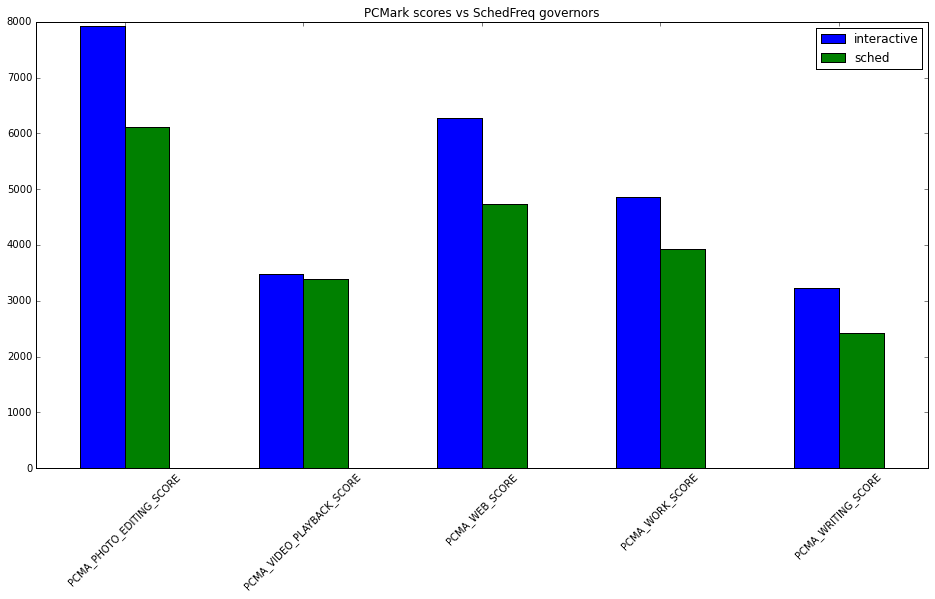

In [64]:
df.plot(kind='bar', rot=45, figsize=(16,8),
        title='PCMark scores vs SchedFreq governors');